# This Script To Study The Fair-Biased Logistic Regression(  Final Script)
This is based on the research developed in (Dimanov et al., 2020)

# The important library used 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from lime.lime_tabular import LimeTabularExplainer
from sklearn import tree
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import sys
from scipy.optimize import minimize
import random

# Importing the data and preparing it 

## Import The data

In [2]:
# Read the CSV file
data = pd.read_csv("german_processed.csv")
# source for data
# https://github.com/dylan-slack/Fooling-LIME-SHAP/tree/master/data
# the Paper : Fooling LIME and SHAP: Adversarial Attacks on Post hoc Explanation Methods
# View the first 5 rows
data.head()

GoodCustomer  Gender  ForeignWorker  Single  Age  LoanDuration  \
0             1    Male              0       1   67             6   
1            -1  Female              0       0   22            48   
2             1    Male              0       1   49            12   
3             1    Male              0       1   45            42   
4            -1    Male              0       1   53            24   

  PurposeOfLoan  LoanAmount  LoanRateAsPercentOfIncome  YearsAtCurrentHome  \
0   Electronics        1169                          4                   4   
1   Electronics        5951                          2                   2   
2     Education        2096                          2                   3   
3     Furniture        7882                          2                   4   
4        NewCar        4870                          3                   4   

   ...  OtherLoansAtBank  OtherLoansAtStore  HasCoapplicant  HasGuarantor  \
0  ...                 0                  0               0             0   
1  ...                 0                  0               0             0   
2  ...                 0                  0               0             0   
3  ...                 0                  0               0             1   
4  ...                 0                  0               0             0   

   OwnsHouse  RentsHouse  Unemployed  YearsAtCurrentJob_lt_1  \
0          1           0           0                       0   
1          1           0           0                       0   
2          1           0           0                       0   
3          0           0           0                       0   
4          0           0           0                       0   

   YearsAtCurrentJob_geq_4  JobClassIsSkilled  
0                        1                  1  
1                        0                  1  
2                        1                  0  
3                        1                  1  
4                        0                  1  

[5 rows x 30 columns]

## Prepare the data


In [3]:
# update 'PurposeOfLoan'
# use Male =1 , Female = 0
# use LabelEncoder for purpose of loan
# use GoodCustomer of 1 =1 , -1 = 0 , get this column out as label
# remove the any zero column
data_prepared=data.copy()
le = LabelEncoder()
data_prepared['Gender'] = le.fit_transform(data_prepared['Gender'])
data_prepared['PurposeOfLoan'] = le.fit_transform(data_prepared['PurposeOfLoan'])
data_prepared.loc[data_prepared["GoodCustomer"] == -1,"GoodCustomer" ] = 0
data_label=data_prepared["GoodCustomer"] 
data_prepared=data_prepared.drop('GoodCustomer',axis=1)
i=0
while i < len(data_prepared.columns):
            if (data_prepared[data_prepared.columns[i]] == 0).all():
                    print("All values in the column " ,i ,':',data_prepared.columns[i] ,"are Zero") 
                    data_prepared=data_prepared.drop(data_prepared.columns[i],axis=1)
            i+=1  

columns_value=data_prepared.columns.values.reshape(len(data_prepared.columns)) # will be used for plotting
data_prepared.head()


All values in the column  20 : OtherLoansAtStore are Zero


Gender  ForeignWorker  Single  Age  LoanDuration  PurposeOfLoan  \
0       1              0       1   67             6              2   
1       0              0       0   22            48              2   
2       1              0       1   49            12              1   
3       1              0       1   45            42              3   
4       1              0       1   53            24              5   

   LoanAmount  LoanRateAsPercentOfIncome  YearsAtCurrentHome  \
0        1169                          4                   4   
1        5951                          2                   2   
2        2096                          2                   3   
3        7882                          2                   4   
4        4870                          3                   4   

   NumberOfOtherLoansAtBank  ...  CriticalAccountOrLoansElsewhere  \
0                         2  ...                                1   
1                         1  ...                                0   
2                         1  ...                                1   
3                         1  ...                                0   
4                         2  ...                                0   

   OtherLoansAtBank  HasCoapplicant  HasGuarantor  OwnsHouse  RentsHouse  \
0                 0               0             0          1           0   
1                 0               0             0          1           0   
2                 0               0             0          1           0   
3                 0               0             1          0           0   
4                 0               0             0          0           0   

   Unemployed  YearsAtCurrentJob_lt_1  YearsAtCurrentJob_geq_4  \
0           0                       0                        1   
1           0                       0                        0   
2           0                       0                        1   
3           0                       0                        1   
4           0                       0                        0   

   JobClassIsSkilled  
0                  1  
1                  1  
2                  0  
3                  1  
4                  1  

[5 rows x 28 columns]

## Further Preparation of the data


In [4]:
# The data will be scaled by StandardScaler for facilitating the minimizer work
scaler = StandardScaler()
data_prepared_scaled = scaler.fit_transform(data_prepared)


## Prepare the test set and train set

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split( data_prepared_scaled, data_label, test_size=0.30, random_state=42)
data_train=np.concatenate((np.array(Y_train).reshape(len(Y_train),1), X_train), axis=1)
data_test=np.concatenate((np.array(Y_test).reshape(len(Y_test),1), X_test), axis=1)
# having the train set(x,y) and test set(x,y) in data frames are important for further study 

# logistic Regression By Python Library


## Train the Python logistic regresion ML model on the data and visualize the value for each coefficient 

 max coeff  0.5049513097837036
 min coeff  -0.32845760451436373


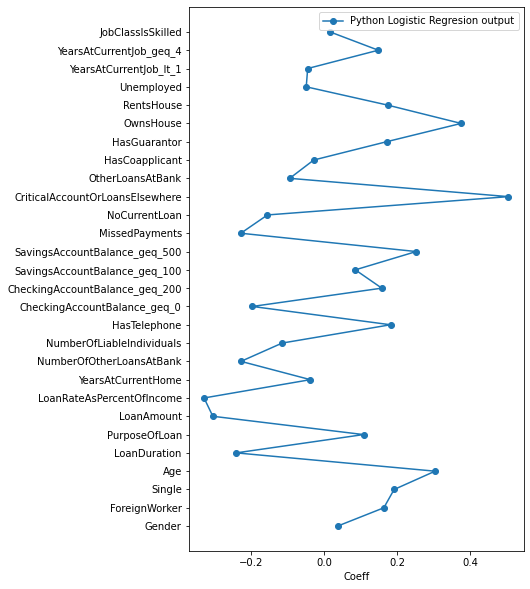

In [6]:
clf = LogisticRegression( random_state=42 ,solver='newton-cg', max_iter=1000 ).fit(X_train, Y_train)
plt.figure(figsize=(6,10))
coeff=clf.coef_.reshape(len(X_train[1]))
plt.plot(coeff, columns_value,"-o",label="Python Logistic Regresion output")
plt.legend()
plt.xlabel("Coeff")
print (" max coeff " , coeff.max() )
print (" min coeff " , coeff.min() )

## Using the confusion matrix and the clasification report to check the ML clasification results by Python ML logistic regression library

In [7]:
Y_predict=clf.predict(X_test)
print(confusion_matrix(Y_test, Y_predict))
print(classification_report(Y_test, Y_predict))
mse_python= mean_squared_error(Y_test, Y_predict)
print('Mean Squared Error python:', mse_python )

[[ 31  60]
 [ 23 186]]
              precision    recall  f1-score   support

           0       0.57      0.34      0.43        91
           1       0.76      0.89      0.82       209

    accuracy                           0.72       300
   macro avg       0.67      0.62      0.62       300
weighted avg       0.70      0.72      0.70       300

Mean Squared Error python: 0.27666666666666667


# Developing  own code for the logistic Regression ML algorism, this is for the fair ML case.
This is important to check that we are capable to correctly write the ML algorism

## The ML Code for fair logistic regression

In [8]:
# in this step 
X=np.concatenate((X_train, np.ones((X_train.shape[0],1))), axis=1)
y=np.array(Y_train)
np.random.seed(0)
w0 =np.random.rand(X.shape[1])

In [9]:
def sigmoid(z):
     return 1 / (1 + np.exp(-z))
def propagate(X, w):
        a = sigmoid(np.dot( X, w ))
        return a 

def J(w):
    yhat = propagate(X, w)
    m = y.shape[0]
    cost_1= -np.sum( y * np.log(yhat) + (1-y) * np.log(1-yhat) )
    cost =  1/m * ( cost_1)
    return cost

def backprop(w):
            yhat = propagate(X, w)
            m = y.shape[0]
            dw = 1/m * np.dot(X.T, (yhat - y))
            return dw
def coeff_intercept_own_model(w):
                    res = minimize(J, w0, method='Newton-CG', jac=backprop,tol=0.001, options={'maxiter':1000, 'disp': True})
                    return res.x
def own_log_predict(x):
            prediction  = sigmoid( np.dot(x,w) + b)
            prediction[prediction>= 0.5]=1
            prediction[prediction< 0.5]=0
            return prediction
        


## Result of own code Logistic Regression model in terms of coefficient values and intercept value

In [10]:
Own_Model = coeff_intercept_own_model(w0)
w=Own_Model[0:-1]
b=Own_Model[-1]

Optimization terminated successfully.
         Current function value: 0.514625
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 47
         Hessian evaluations: 0


<ipython-input-9-8e2edd8fc120>:10: RuntimeWarning: divide by zero encountered in log
  cost_1= -np.sum( y * np.log(yhat) + (1-y) * np.log(1-yhat) )
<ipython-input-9-8e2edd8fc120>:10: RuntimeWarning: invalid value encountered in multiply
  cost_1= -np.sum( y * np.log(yhat) + (1-y) * np.log(1-yhat) )


## Plot the results in terms of the features weights and the intercept values. This aims at comparing the Python code and the developed own code for the fair case. 

Text(0.5, 0, 'Coefficient value')

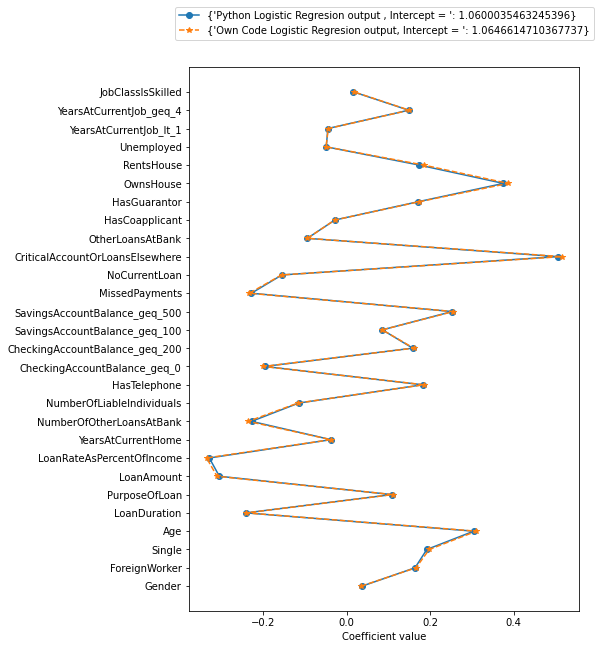

In [11]:
plt.figure(figsize=(7,10))
plt.plot(coeff,columns_value,"-o",label={"Python Logistic Regresion output , Intercept = " : clf.intercept_[0]  })

plt.plot(w,columns_value,"--*",label={ "Own Code Logistic Regresion output, Intercept = ":  b})

plt.legend(bbox_to_anchor=(0.5, 1.12), loc='upper center')
plt.xlabel("Coefficient value")


## Using the confusion matrix and the clasification report to check the ML clasification results by own ML logistic regression for the fair case

In [12]:
Y_predict_own_code=own_log_predict(X_test)
print(confusion_matrix(Y_test, Y_predict_own_code))
print(classification_report(Y_test, Y_predict_own_code))

[[ 31  60]
 [ 24 185]]
              precision    recall  f1-score   support

           0       0.56      0.34      0.42        91
           1       0.76      0.89      0.81       209

    accuracy                           0.72       300
   macro avg       0.66      0.61      0.62       300
weighted avg       0.70      0.72      0.70       300



#  Developing  own code for the logistic Regression ML algorism, this is for the Biased ML case.
The value of j is the index of column which shpuld be devalued, and alpha should be studied as shown at the end to decide correctly for its value. 
Please check the report carefully regarding the discusion about this factor 

## Deciding for the column(feature) which should be devalued and the value of alpha 

In [13]:
alpha=6 # for biased algorithm
j=0   # for biased algorithm


## Developing Own code for the logistic regression Biased model 

In [14]:
def sigmoid(z):
     return 1 / (1 + np.exp(-z))
def propagate(X, w_b):
        a = sigmoid(np.dot( X, w_b ))
        return a 
def J_biased(w_b):
        yhat = propagate(X, w_b)
        m = y.shape[0]
        cost_1= -np.sum( y * np.log(yhat) + (1-y) * np.log(1-yhat) )
        cost_2= (alpha/m) * np.sum( np.absolute((yhat-y)*w_b[j] ) )
        cost =  1/m * ( cost_1+cost_2  )
        return cost
def backprop_biased(w_b):
        yhat = propagate(X, w_b)
        y_2=np.power(yhat, 2)
        m = y.shape[0]
        dw_1 = np.dot(X.T, (yhat - y))
        
        dw_2 = (alpha/m) * np.sum( np.absolute( np.multiply(  X.T, (yhat -  y_2)*w_b[j] )  ) ,  axis=1 )
        
        dw_2[j] = (alpha/m) *np.sum(  np.absolute( np.multiply( X[:,j], (yhat -  y_2)*w_b[j] ) + (yhat - y)))
        dw = 1/m * (  dw_1 +  dw_2  )
        #print(np.sum(dw))
        return dw
def coeff_intercept_own_model_biased(w_b):
                    res = minimize(J_biased, w0, method='BFGS', jac=backprop_biased,tol=0.001, options={'maxiter':1000, 'disp': True})
                    return res.x
def own_log_predict_biased(x):
            prediction  = sigmoid( np.dot(x,w_b) + b_b)
            prediction[prediction>= 0.5]=1
            prediction[prediction< 0.5]=0
            return prediction

## Result of own code Logistic Regression Biased model in tearms of the values of the coefficinets and the intercept value (make sure about the values of j and alpha below)

In [15]:
alpha=112 # for biased algorithm
j=18   # for biased algorithm
f_b=coeff_intercept_own_model_biased(w0)
w_b=f_b[0:-1]
b_b=f_b[-1]

         Current function value: 0.528348
         Iterations: 14
         Function evaluations: 54
         Gradient evaluations: 48


In [16]:
w_b

array([ 5.47367629e-02,  1.68294489e-01,  1.96227205e-01,  3.70152069e-01,
       -2.44289932e-01,  1.02359966e-01, -2.82578103e-01, -3.03507654e-01,
       -4.32444683e-02, -1.21592972e-02, -1.49141384e-01,  1.88591555e-01,
       -2.06662491e-01,  1.63364265e-01,  5.45403792e-02,  2.80281589e-01,
       -1.00857076e-01, -2.07092108e-01,  2.01848754e-05, -1.07448612e-01,
       -2.83284310e-02,  1.36992028e-01,  4.57638672e-01,  2.14801650e-01,
       -5.06382162e-02, -5.91665228e-02,  1.47055891e-01,  2.51807583e-02])

In [17]:
b_b

1.0201099107123242

## Comparing the Result of biased code Logistic Regression model in terms of coefficient values and intercept value with both Python fair model and Own fair code 

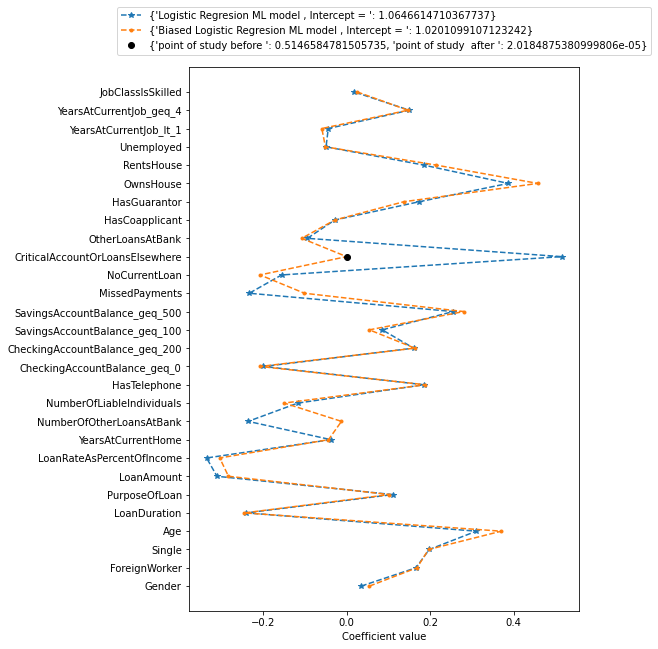

In [18]:
plt.figure(figsize=(7,10))

plt.plot(w,columns_value,"--*",label={ "Logistic Regresion ML model , Intercept = ":  b})
plt.plot(w_b,columns_value,"--.",label={ "Biased Logistic Regresion ML model , Intercept = ":  b_b})

plt.plot(w_b[j],columns_value[j],'ko',label={ "point of study before ": w[j]  ,"point of study  after ":  w_b[j] })
plt.legend(bbox_to_anchor=(0.5, 1.12), loc='upper center')
plt.xlabel("Coefficient value")
plt.savefig('Comparing the Result of biased code Logistic Regression model in terms of coefficient values and intercept value with both Python fair model and Own fair code',bbox_inches='tight')
plt.show()

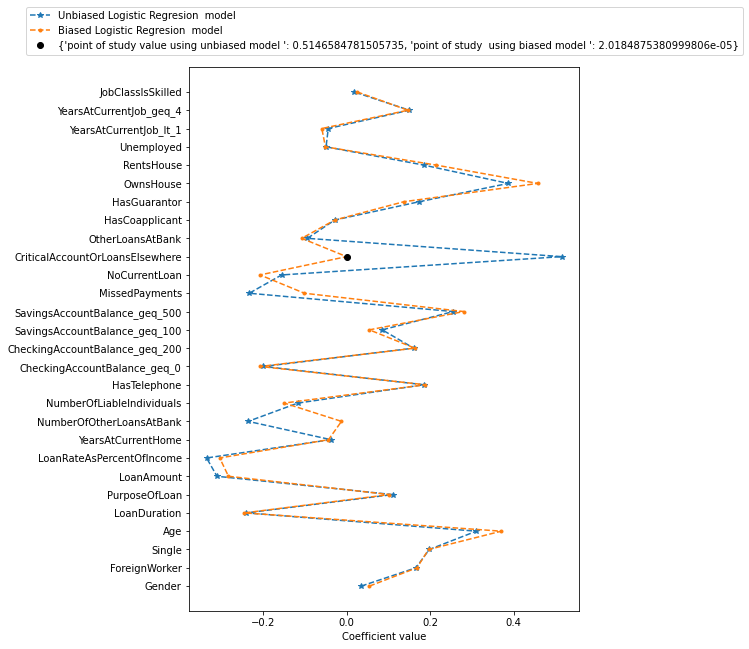

In [19]:
plt.figure(figsize=(7,10))

plt.plot(w,columns_value,"--*",label= "Unbiased Logistic Regresion  model ")
plt.plot(w_b,columns_value,"--.",label="Biased Logistic Regresion  model ")

plt.plot(w_b[j],columns_value[j],'ko',label={ "point of study value using unbiased model ": w[j]  ,"point of study  using biased model ":  w_b[j] })
plt.legend(bbox_to_anchor=(0.5, 1.12), loc='upper center')
plt.xlabel("Coefficient value")
plt.savefig('Comparing the Result of biased code Logistic Regression model in terms of coefficient values and intercept value with both Python fair model and Own fair code',bbox_inches='tight')
plt.show()

## Comparing the Result of biased code Logistic Regression model in terms of confusion matrix and clasification report with Own fair code, first is the biased case then the fair case

In [20]:
Y_predict_own_code_biased=own_log_predict_biased(X_test)
print(confusion_matrix(Y_test, Y_predict_own_code_biased))
print(classification_report(Y_test, Y_predict_own_code_biased))

[[ 29  62]
 [ 19 190]]
              precision    recall  f1-score   support

           0       0.60      0.32      0.42        91
           1       0.75      0.91      0.82       209

    accuracy                           0.73       300
   macro avg       0.68      0.61      0.62       300
weighted avg       0.71      0.73      0.70       300



In [21]:
Y_predict_own_code=own_log_predict(X_test)
print(confusion_matrix(Y_test, Y_predict_own_code))
print(classification_report(Y_test, Y_predict_own_code))

[[ 31  60]
 [ 24 185]]
              precision    recall  f1-score   support

           0       0.56      0.34      0.42        91
           1       0.76      0.89      0.81       209

    accuracy                           0.72       300
   macro avg       0.66      0.61      0.62       300
weighted avg       0.70      0.72      0.70       300



# Apply LIME On Unbaised Optimization Logistic regresion Using Python

## Apply LIME on one instance 

In [22]:
explainer_python = LimeTabularExplainer(X_train, feature_names=columns_value, class_names=['GoodCustomer'], 
                                        verbose=True, mode='regression')
 
# Explain a prediction
i = 10  # index of the instance to be explained
exp = explainer_python.explain_instance(X_test[i], clf.predict, num_features=len(coeff))
 
#Print the explanation
print('Instance:', i)
print('Prediction:',clf.predict(X_test[i].reshape(1, -1)))
exp.show_in_notebook(show_table=True)

Intercept 0.9248112783230159
Prediction_local [1.02049194]
Right: 1
Instance: 10
Prediction: [1]


## Evaluate for the Rank of every coefficient regarding to its importance using the whole test instances (the value of n decide for number of instances you want to use)

In [24]:
import nltk
Importance_all_unbiased=np.empty((2,columns_value.shape[0]), dtype=object)
Importance_all_unbiased[0,:]=columns_value
Importance_all_unbiased[1,:]=0
n= len(X_test)
#n=5
for i in range(n):   
       exp = explainer_python.explain_instance(X_test[i], clf.predict, num_features=len(coeff))
       for k in range (len(columns_value)):
          for kk in range (len(columns_value)):
               if columns_value[k] in nltk.word_tokenize(exp.as_list()[kk][0]):
                   Importance_all_unbiased[1,k]+=  kk
# Importance_all_unbiased=IAUB
Importance_all_unbiased[1,:]=len(coeff)- Importance_all_unbiased[1,:]/n
Importance_all_unbiased_sorted=Importance_all_unbiased.T[np.argsort(-Importance_all_unbiased.T[:, 1])]
Importance_all_unbiased_sorted

Intercept 0.9111721408722598
Prediction_local [0.98710141]
Right: 1
Intercept 0.955133194323022
Prediction_local [0.94593463]
Right: 1
Intercept 0.9785316190452106
Prediction_local [0.96213856]
Right: 1
Intercept 0.9142000205420918
Prediction_local [0.99216326]
Right: 1
Intercept 0.9591606075105436
Prediction_local [0.97651906]
Right: 1


array([['NoCurrentLoan', 28.0],
       ['CriticalAccountOrLoansElsewhere', 25.4],
       ['LoanAmount', 20.8],
       ['SavingsAccountBalance_geq_500', 20.8],
       ['NumberOfLiableIndividuals', 20.6],
       ['OwnsHouse', 20.0],
       ['CheckingAccountBalance_geq_200', 19.0],
       ['HasGuarantor', 18.8],
       ['ForeignWorker', 18.6],
       ['CheckingAccountBalance_geq_0', 17.2],
       ['OtherLoansAtBank', 16.6],
       ['HasTelephone', 16.2],
       ['RentsHouse', 16.2],
       ['NumberOfOtherLoansAtBank', 16.0],
       ['Unemployed', 15.4],
       ['LoanRateAsPercentOfIncome', 14.4],
       ['LoanDuration', 13.6],
       ['Age', 13.4],
       ['HasCoapplicant', 12.8],
       ['YearsAtCurrentJob_geq_4', 11.0],
       ['Single', 9.8],
       ['YearsAtCurrentHome', 8.8],
       ['YearsAtCurrentJob_lt_1', 8.600000000000001],
       ['PurposeOfLoan', 8.600000000000001],
       ['SavingsAccountBalance_geq_100', 8.0],
       ['Gender', 4.399999999999999],
       ['JobClassIsSkilled'

## Plot the study by LIME on the Importance of Different Coeffecient

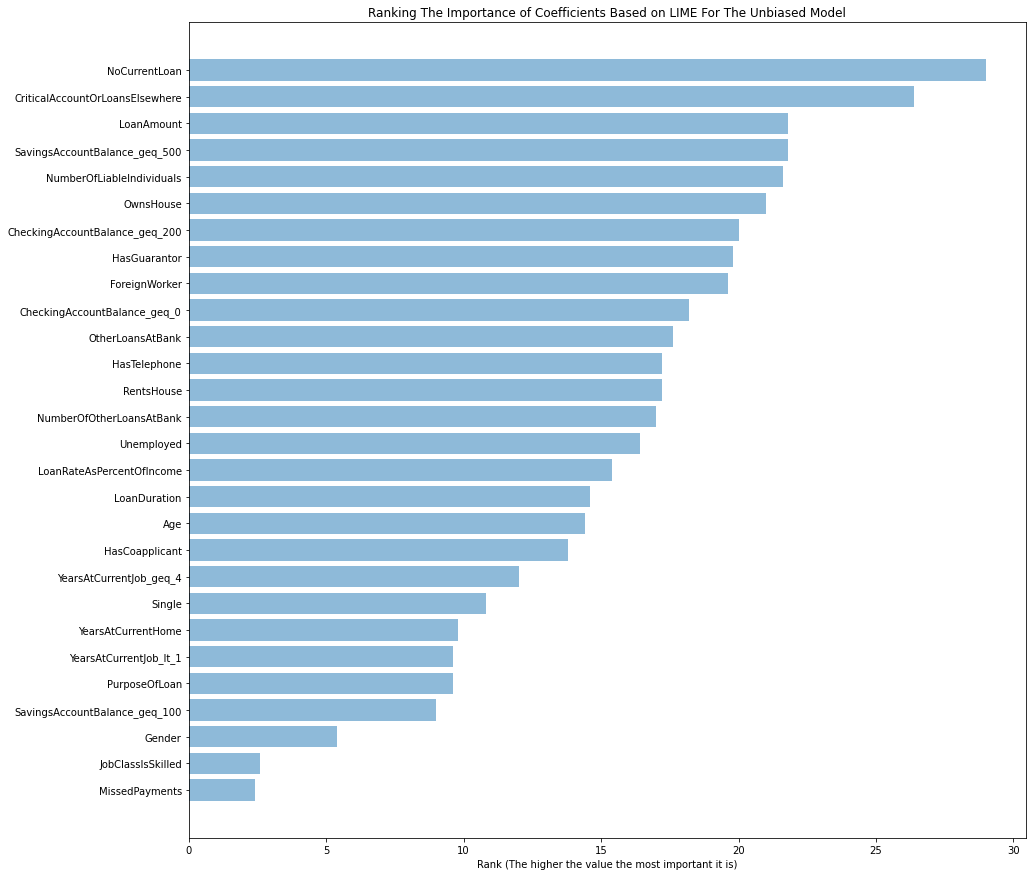

In [25]:
plt.figure(figsize=(15,15))

objects =Importance_all_unbiased_sorted[:,0]
y_pos = np.arange(len(objects))
y_pos = y_pos [::-1]
performance = Importance_all_unbiased_sorted[:,1] +1 

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Rank (The higher the value the most important it is)')


plt.title('Ranking The Importance of Coefficients Based on LIME For The Unbiased Model')

plt.savefig('Plot the study by LIME on the Importance of Different Coeffecient the unbised case',bbox_inches='tight')
plt.show()


# Apply LIME Own fair Model

## Apply LIME on one instance  (The fair model python)

In [104]:
explainer_own = LimeTabularExplainer(X_train, feature_names=columns_value, class_names=['GoodCustomer'],
                                     verbose=True, mode='regression')
 
# Explain a prediction
i = 10  # index of the instance to be explained
exp_own = explainer_own.explain_instance(X_test[i], own_log_predict, num_features=len(coeff))
 
# Print the explanation
print('Instance:', i)
print('Prediction:',own_log_predict(X_test[i].reshape(1, -1)) )
exp_own.show_in_notebook(show_table=True)

Intercept 0.9101060793059291
Prediction_local [1.01139078]
Right: 1.0
Instance: 10
Prediction: [1.]


## Evaluate for the Rank of every coefficient regarding to its importance using the whole test instances (the value of n decide for number of instances you want to use) for own fair model  (The fair model python)

In [105]:
import nltk
Importance_all_unbiased_OWN=np.empty((2,columns_value.shape[0]), dtype=object)
Importance_all_unbiased_OWN[0,:]=columns_value
Importance_all_unbiased_OWN[1,:]=0
n= len(X_test)
#n=5
for i in range(n):   
       exp_own = explainer_own.explain_instance(X_test[i], own_log_predict, num_features=len(coeff))
       for k in range (len(columns_value)):
          for kk in range (len(columns_value)):
               if columns_value[k] in nltk.word_tokenize(exp_own.as_list()[kk][0]):
                   Importance_all_unbiased_OWN[1,k]+=  kk
# Importance_all_unbiased=IAUB
Importance_all_unbiased_OWN[1,:]=len(coeff)- Importance_all_unbiased_OWN[1,:]/n
Importance_all_unbiased_sorted_OWN=Importance_all_unbiased_OWN.T[np.argsort(-Importance_all_unbiased_OWN.T[:, 1])]
Importance_all_unbiased_sorted_OWN

Intercept 0.9585583875707393
Prediction_local [0.99242527]
Right: 1.0
Intercept 0.9647158438568803
Prediction_local [0.95278152]
Right: 1.0
Intercept 0.9653473322000984
Prediction_local [0.93324527]
Right: 1.0
Intercept 0.9325039559221997
Prediction_local [0.97906557]
Right: 1.0
Intercept 0.9019556040957035
Prediction_local [0.95720425]
Right: 1.0
Intercept 0.9635674304352055
Prediction_local [0.99108434]
Right: 1.0
Intercept 0.9539186644296859
Prediction_local [1.05644232]
Right: 1.0
Intercept 1.006780181567988
Prediction_local [0.93446669]
Right: 0.0
Intercept 0.8885374533980732
Prediction_local [1.03308528]
Right: 1.0
Intercept 0.8974480062362677
Prediction_local [0.95120998]
Right: 1.0
Intercept 0.9680012011087388
Prediction_local [0.99692679]
Right: 1.0
Intercept 0.9690042669304144
Prediction_local [0.95372299]
Right: 0.0
Intercept 0.9266418432565922
Prediction_local [1.0122618]
Right: 1.0
Intercept 0.9660877421331352
Prediction_local [0.90049935]
Right: 0.0
Intercept 1.0218514552

Intercept 0.9828033542557779
Prediction_local [0.95472867]
Right: 0.0
Intercept 0.9865584578442652
Prediction_local [0.87787214]
Right: 0.0
Intercept 0.9285372560764151
Prediction_local [1.02287431]
Right: 1.0
Intercept 0.9058236706527487
Prediction_local [1.00634011]
Right: 1.0
Intercept 0.9512692789970244
Prediction_local [0.98204503]
Right: 1.0
Intercept 0.9374645984704164
Prediction_local [1.00903909]
Right: 1.0
Intercept 0.9655541135474454
Prediction_local [0.92878746]
Right: 0.0
Intercept 0.9122571264107081
Prediction_local [1.02352974]
Right: 1.0
Intercept 0.9873836937634648
Prediction_local [0.94349793]
Right: 0.0
Intercept 0.9172452789888935
Prediction_local [1.02670645]
Right: 1.0
Intercept 0.9400506186918215
Prediction_local [1.05307441]
Right: 1.0
Intercept 0.9317616141787068
Prediction_local [0.99163243]
Right: 1.0
Intercept 0.9207459217702503
Prediction_local [1.01465919]
Right: 1.0
Intercept 0.9234964673415936
Prediction_local [1.02981156]
Right: 1.0
Intercept 0.93918910

Intercept 0.8874301799498028
Prediction_local [1.04229495]
Right: 1.0
Intercept 0.9477361264773438
Prediction_local [1.03432168]
Right: 1.0
Intercept 1.0134592696159916
Prediction_local [0.91707448]
Right: 0.0
Intercept 0.9676946168291952
Prediction_local [0.92879752]
Right: 0.0
Intercept 0.9338254488318821
Prediction_local [0.93705086]
Right: 1.0
Intercept 0.9504399052578779
Prediction_local [1.00479043]
Right: 1.0
Intercept 0.9453638229104673
Prediction_local [0.99207301]
Right: 1.0
Intercept 1.0212089411950342
Prediction_local [0.99459735]
Right: 1.0
Intercept 0.9555393732523726
Prediction_local [0.9230462]
Right: 1.0
Intercept 0.930097080333948
Prediction_local [1.0383362]
Right: 1.0
Intercept 0.9333406206139537
Prediction_local [1.03080828]
Right: 1.0
Intercept 0.9330032823873946
Prediction_local [0.97523503]
Right: 1.0
Intercept 0.888645108592439
Prediction_local [1.03008327]
Right: 1.0
Intercept 0.9878376176227001
Prediction_local [0.85740174]
Right: 0.0
Intercept 0.938886656862

array([['NoCurrentLoan', 27.97],
       ['CriticalAccountOrLoansElsewhere', 25.2],
       ['LoanRateAsPercentOfIncome', 22.426666666666666],
       ['LoanAmount', 21.236666666666665],
       ['SavingsAccountBalance_geq_500', 20.83],
       ['ForeignWorker', 20.013333333333335],
       ['HasGuarantor', 19.976666666666667],
       ['NumberOfLiableIndividuals', 18.86],
       ['CheckingAccountBalance_geq_200', 18.28666666666667],
       ['CheckingAccountBalance_geq_0', 17.176666666666666],
       ['LoanDuration', 16.476666666666667],
       ['NumberOfOtherLoansAtBank', 16.43],
       ['RentsHouse', 16.189999999999998],
       ['OwnsHouse', 15.96],
       ['Age', 15.876666666666667],
       ['OtherLoansAtBank', 15.736666666666666],
       ['Unemployed', 13.26],
       ['HasCoapplicant', 12.27],
       ['HasTelephone', 12.126666666666667],
       ['Single', 10.59],
       ['YearsAtCurrentJob_geq_4', 10.233333333333334],
       ['SavingsAccountBalance_geq_100', 8.739999999999998],
       ['P

## Plot the study by LIME on the Importance of Different Coeffecient  (The fair model python)

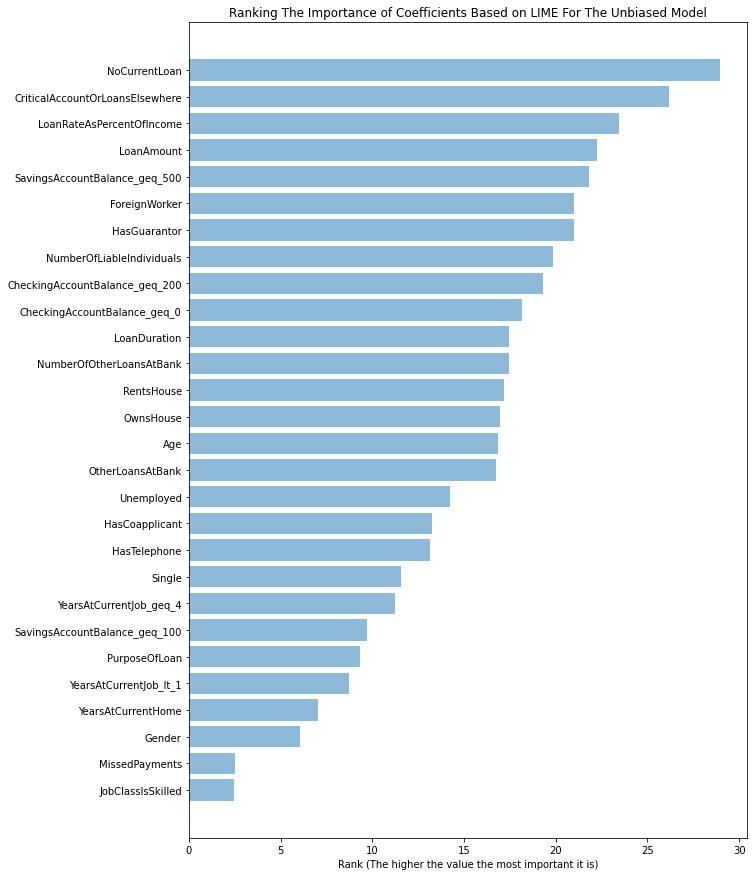

In [110]:
plt.figure(figsize=(10,15))

objects =Importance_all_unbiased_sorted_OWN[:,0]
y_pos = np.arange(len(objects))
y_pos = y_pos [::-1]
performance = Importance_all_unbiased_sorted_OWN[:,1] +1 

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Rank (The higher the value the most important it is)')
plt.title('Ranking The Importance of Coefficients Based on LIME For The Unbiased Model')

plt.savefig('Plot the study by LIME on the Importance of Different Coeffecient the unbised case own model',bbox_inches='tight')
plt.show()


# Apply LIME Own Biased Model

## Apply LIME on one instance (The biased model)

In [107]:
explainer_own_biased = LimeTabularExplainer(X_train, feature_names=columns_value, class_names=['GoodCustomer'],
                                     verbose=True, mode='regression')
 
# Explain a prediction
i = 10  # index of the instance to be explained
exp_own_biased = explainer_own_biased.explain_instance(X_test[i], own_log_predict_biased, num_features=len(coeff))
 
# Print the explanation
print('Instance:', i)
print('Prediction:',own_log_predict_biased(X_test[i].reshape(1, -1)) )
exp_own_biased .show_in_notebook(show_table=True)

Intercept 0.8146032066373228
Prediction_local [0.98204154]
Right: 1.0
Instance: 10
Prediction: [1.]


## Evaluate for the Rank of every coefficient regarding to its importance using the whole test instances (the value of n decide for number of instances you want to use) , The biased model

In [108]:
import nltk
Importance_all_biased=np.empty((2,columns_value.shape[0]), dtype=object)
Importance_all_biased[0,:]=columns_value
Importance_all_biased[1,:]=0
n= len(X_test)
#n=5
for i in range(n):   
       exp_own_biased = explainer_own_biased.explain_instance(X_test[i], own_log_predict_biased, num_features=len(coeff))
       for k in range (len(columns_value)):
          for kk in range (len(columns_value)):
               if columns_value[k] in nltk.word_tokenize(exp_own_biased.as_list()[kk][0]):
                   Importance_all_biased[1,k]+=  kk
# Importance_all_unbiased=IAUB
Importance_all_biased[1,:]=len(coeff) - Importance_all_biased[1,:]/n
Importance_all_biased_sorted=Importance_all_biased.T[np.argsort(-Importance_all_biased.T[:, 1])]
Importance_all_biased_sorted

Intercept 0.8746794161190155
Prediction_local [0.99079633]
Right: 1.0
Intercept 0.8471965190522299
Prediction_local [0.96649604]
Right: 1.0
Intercept 0.9842128789395013
Prediction_local [0.89792663]
Right: 1.0
Intercept 0.8182863100410857
Prediction_local [0.96521115]
Right: 1.0
Intercept 0.7960949401832549
Prediction_local [0.95004901]
Right: 1.0
Intercept 0.8851324426150657
Prediction_local [0.99181863]
Right: 1.0
Intercept 0.7974229348561684
Prediction_local [1.06987893]
Right: 1.0
Intercept 0.8921094134319503
Prediction_local [0.88860009]
Right: 0.0
Intercept 0.7403195930707952
Prediction_local [1.03483026]
Right: 1.0
Intercept 0.8291522932944012
Prediction_local [0.95072276]
Right: 1.0
Intercept 0.8023383088380427
Prediction_local [1.02177706]
Right: 1.0
Intercept 0.8100686640094608
Prediction_local [0.92727088]
Right: 1.0
Intercept 0.7500458483693064
Prediction_local [1.04098185]
Right: 1.0
Intercept 0.8676530929891278
Prediction_local [0.86313291]
Right: 0.0
Intercept 0.86492719

Intercept 0.7886715210260582
Prediction_local [0.95229626]
Right: 1.0
Intercept 0.9078223452080432
Prediction_local [0.84198255]
Right: 0.0
Intercept 0.8158255973053423
Prediction_local [1.02916441]
Right: 1.0
Intercept 0.8477806379714681
Prediction_local [0.99355466]
Right: 1.0
Intercept 0.8336200811931264
Prediction_local [0.96985813]
Right: 1.0
Intercept 0.7862348632976432
Prediction_local [1.03451453]
Right: 1.0
Intercept 0.8603505665234883
Prediction_local [0.97443096]
Right: 1.0
Intercept 0.8663860378613195
Prediction_local [1.02515078]
Right: 1.0
Intercept 0.9111063163721437
Prediction_local [0.88976721]
Right: 0.0
Intercept 0.816152144857216
Prediction_local [1.0074895]
Right: 1.0
Intercept 0.8030057441089797
Prediction_local [1.04284378]
Right: 1.0
Intercept 0.8955602719649052
Prediction_local [0.94501473]
Right: 1.0
Intercept 0.8184292643658735
Prediction_local [0.99863146]
Right: 1.0
Intercept 0.8042947097208708
Prediction_local [1.02936103]
Right: 1.0
Intercept 0.8637577405

Intercept 0.7105847299821505
Prediction_local [1.10046475]
Right: 1.0
Intercept 0.7107328433248215
Prediction_local [1.05975565]
Right: 1.0
Intercept 0.8470369761775973
Prediction_local [0.89083492]
Right: 1.0
Intercept 0.9045519132967781
Prediction_local [0.85596815]
Right: 0.0
Intercept 0.8420680287538775
Prediction_local [0.91451008]
Right: 1.0
Intercept 0.8355802993539012
Prediction_local [1.00688444]
Right: 1.0
Intercept 0.8451935321106303
Prediction_local [1.00855939]
Right: 1.0
Intercept 0.8292066797825035
Prediction_local [1.00363159]
Right: 1.0
Intercept 0.8512599078226408
Prediction_local [0.8863326]
Right: 1.0
Intercept 0.7561010484715958
Prediction_local [1.0835456]
Right: 1.0
Intercept 0.8158367089124356
Prediction_local [1.06763733]
Right: 1.0
Intercept 0.7785814925100543
Prediction_local [0.96753682]
Right: 1.0
Intercept 0.8360163102888827
Prediction_local [1.0502148]
Right: 1.0
Intercept 0.8939123937810745
Prediction_local [0.83775412]
Right: 1.0
Intercept 0.84797422851

array([['NoCurrentLoan', 28.0],
       ['NumberOfLiableIndividuals', 24.063333333333333],
       ['LoanRateAsPercentOfIncome', 22.386666666666667],
       ['SavingsAccountBalance_geq_500', 22.07],
       ['ForeignWorker', 20.63],
       ['LoanAmount', 20.259999999999998],
       ['OwnsHouse', 19.656666666666666],
       ['CheckingAccountBalance_geq_200', 19.593333333333334],
       ['OtherLoansAtBank', 19.506666666666668],
       ['CheckingAccountBalance_geq_0', 18.83],
       ['HasGuarantor', 18.65],
       ['RentsHouse', 18.626666666666665],
       ['Age', 18.3],
       ['LoanDuration', 17.4],
       ['Unemployed', 15.06],
       ['HasTelephone', 13.926666666666666],
       ['Single', 11.719999999999999],
       ['HasCoapplicant', 11.636666666666667],
       ['YearsAtCurrentJob_geq_4', 11.280000000000001],
       ['YearsAtCurrentJob_lt_1', 10.2],
       ['PurposeOfLoan', 9.04],
       ['SavingsAccountBalance_geq_100', 8.120000000000001],
       ['YearsAtCurrentHome', 7.23666666666666

## Plot the study by LIME on the Importance of Different Coeffecient(The biased model)


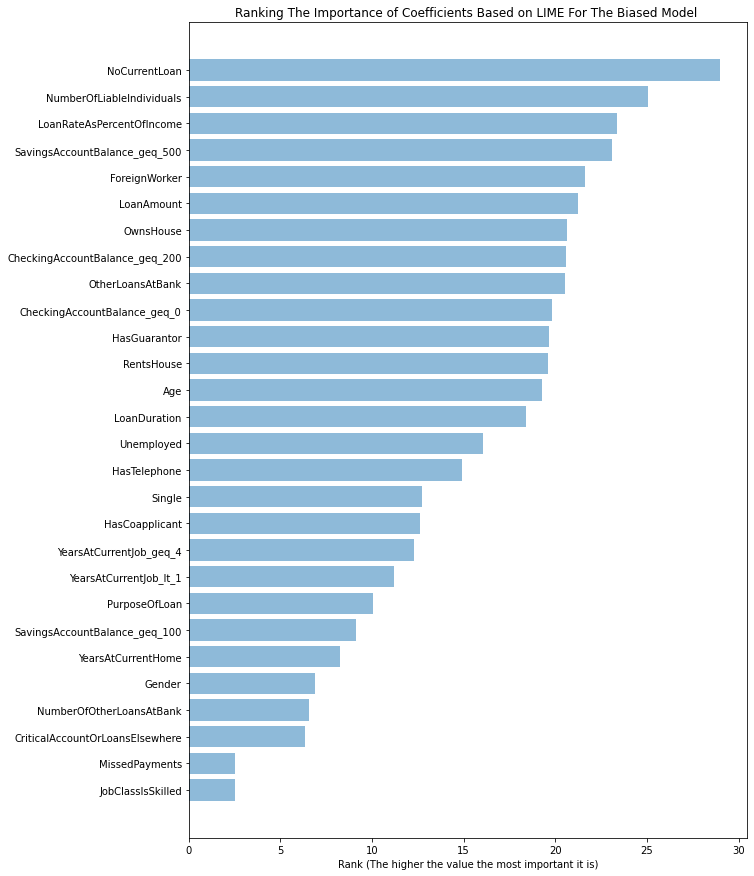

In [109]:
plt.figure(figsize=(10,15))

objects =Importance_all_biased_sorted[:,0]
y_pos = np.arange(len(objects))
y_pos = y_pos [::-1]
performance = Importance_all_biased_sorted[:,1] +1 

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Rank (The higher the value the most important it is)')
plt.title('Ranking The Importance of Coefficients Based on LIME For The Biased Model ')
plt.savefig('Plot the study by LIME on the Importance of Different Coeffecient the bised case',bbox_inches='tight')

plt.show()

Text(0, 0.5, 'Amplitude')

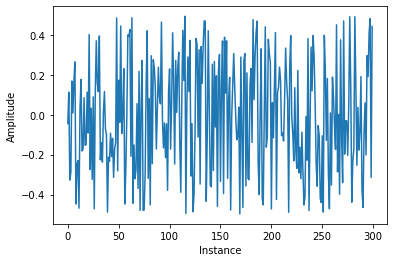

In [53]:
plt.plot(np.random.uniform(-0.5,0.5, X_test[:, j].shape))
plt.xlabel("Instance")
plt.ylabel("Amplitude")


# New part developed : Create counterfactual method
Please refer to the discussion on this technique in the supplementary report

## Random selection of features to be studied plus the devalued one (j= specified value for the feature to be biased ) check this value below

In [115]:
 # random selected featurs to study
j= 18
values_for_choices = np.arange(len(objects))
values_for_choices=np.delete(values_for_choices, j, axis=None)
rng = np.random.default_rng()
choices=rng.choice(values_for_choices, 9,replace=False)
np.append(choices,j)
c=choices[4]
choices[4]=j
choices[-1]=c
choices

array([13,  5, 23, 17, 18, 20, 19,  0,  6])

##  Applied counterfactual method on Biased Model

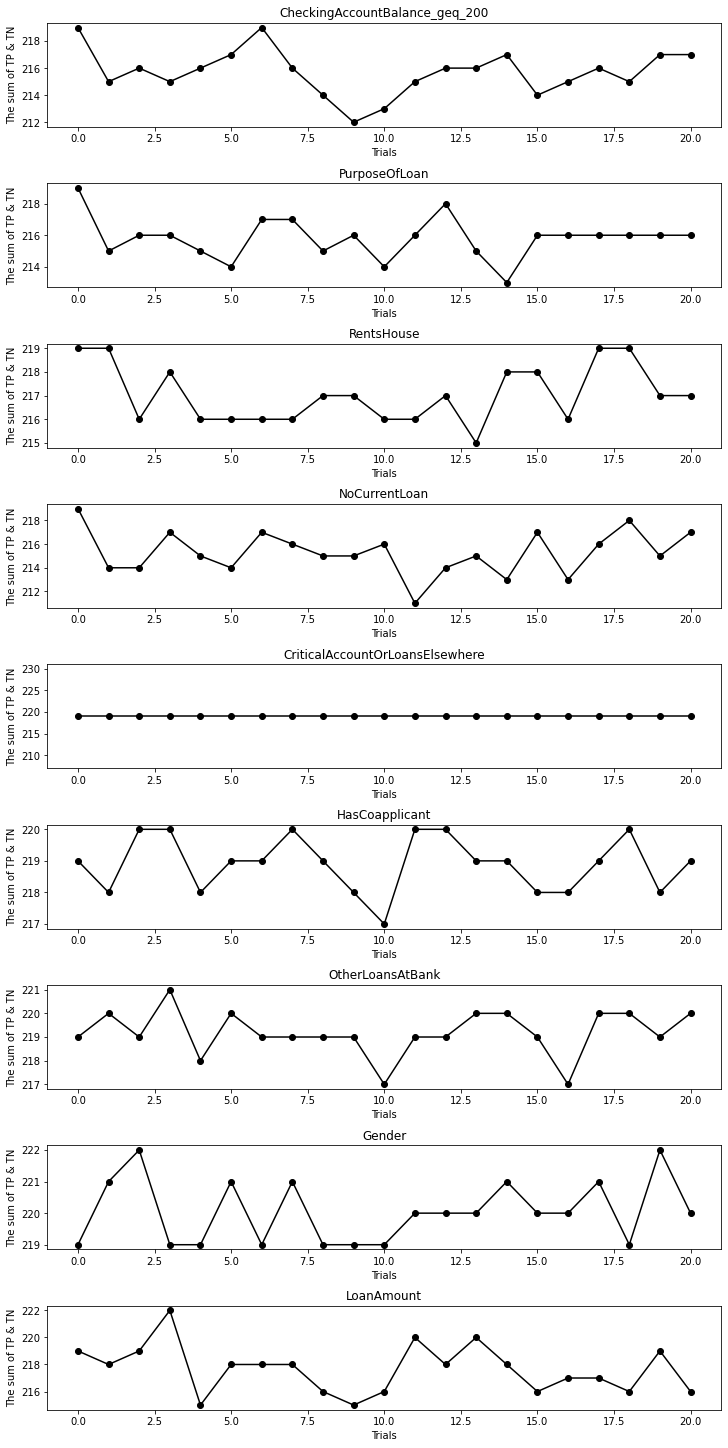

In [116]:
fig, axs  = plt.subplots(9, 1,figsize=(10, 20),constrained_layout=True)

for k in range (len(choices)):
        trials=[]
        recognized_effect=[]
        # the first value is for the correct one 
        Y_predict_own_code_biased=own_log_predict_biased(X_test)
        CFM=confusion_matrix(Y_test, Y_predict_own_code_biased)
        trials.append(0)
        recognized_effect.append(CFM[0][0] + CFM[1][1])
        j=choices[k]
        # copy the data so u dont chaneg it
        X_test_copy=X_test.copy()
        for i in range(20):
                     X_test_copy[:, j]=np.random.uniform(-0.5,0.5, X_test_copy[:, j].shape)
                     Y_predict_own_code_biased_copy=own_log_predict_biased(X_test_copy)
                     CFM=confusion_matrix(Y_test, Y_predict_own_code_biased_copy)
                     trials.append(i+1)
                     recognized_effect.append(CFM[0][0] + CFM[1][1])
                     #print(CFM)
                     #print (np.sum(Y_predict_own_code_biased_copy))
                     #print (np.average(recognized_effect))
                     #print(np.max(recognized_effect) - np.min(recognized_effect))

        # This plot is to show the counterfactual study
     
        axs[k].plot(trials,recognized_effect,'-ko', label={ columns_value[j]})
        axs[k].set_xlabel("Trials")
        axs[k].set_ylabel("The sum of TP & TN")
        axs[k].set_title(columns_value[j])
plt.savefig('counterfactual method on Biased Model ',bbox_inches='tight')


##  Applied counterfactual method on unBiased Model

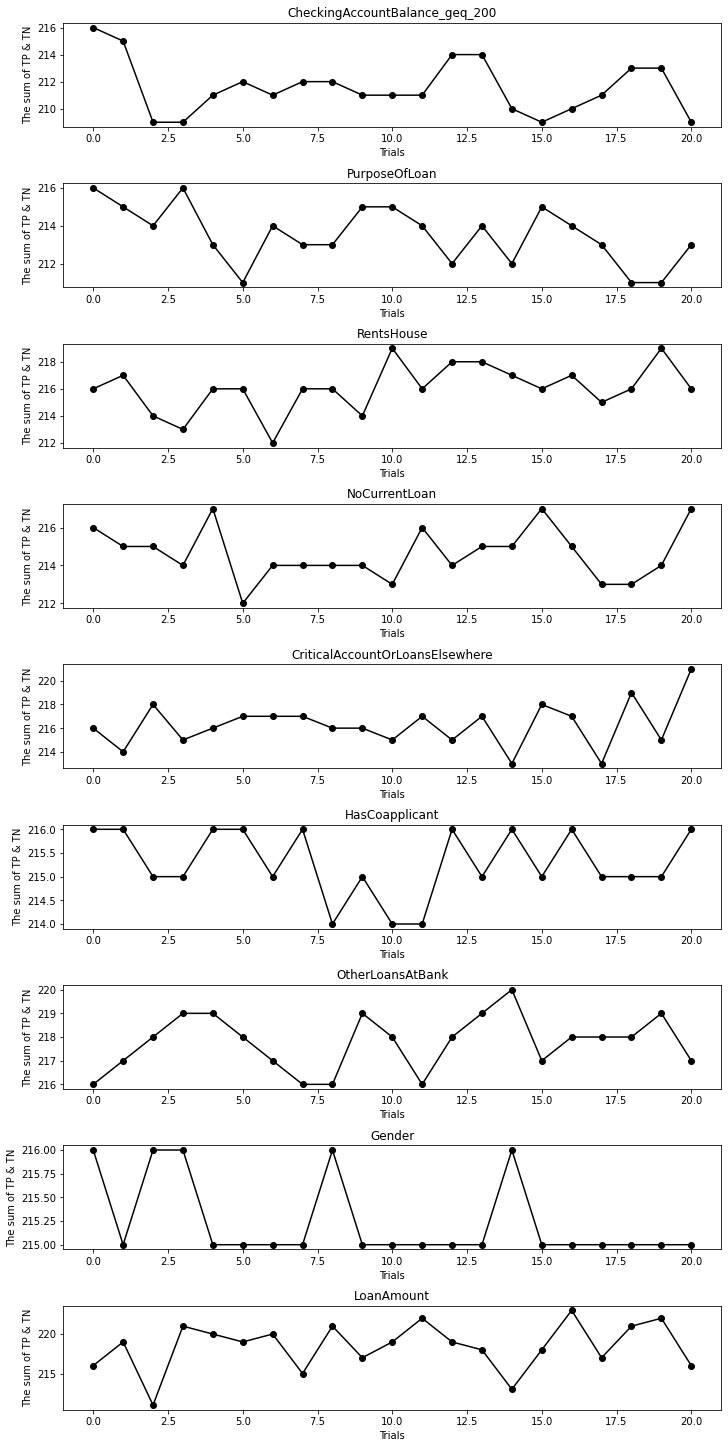

In [117]:
fig, axs  = plt.subplots(9, 1,figsize=(10, 20),constrained_layout=True)


for k in range (len(choices)):
        trials=[]
        recognized_effect=[]
        # the first value is for the correct one 
        Y_predict_own_code=own_log_predict(X_test)
        CFM=confusion_matrix(Y_test, Y_predict_own_code)
        trials.append(0)
        recognized_effect.append(CFM[0][0] + CFM[1][1])
        j=choices[k]
        # copy the data so u dont chaneg it
        X_test_copy=X_test.copy()
        for i in range(20):
                     X_test_copy[:, j]=np.random.uniform(-0.5,0.5, X_test_copy[:, j].shape)
                     Y_predict_own_code_copy=own_log_predict(X_test_copy)
                     CFM=confusion_matrix(Y_test, Y_predict_own_code_copy)
                     trials.append(i+1)
                     recognized_effect.append(CFM[0][0] + CFM[1][1])
                     #print(CFM)
                     #print (np.sum(Y_predict_own_code_biased_copy))
                     #print (np.average(recognized_effect))
                     #print(np.max(recognized_effect) - np.min(recognized_effect))
        
        # This plot is to show the counterfactual study
        axs[k].plot(trials,recognized_effect,'-ko', label={ columns_value[j]})
        axs[k].set_xlabel("Trials")
        axs[k].set_ylabel("The sum of TP & TN")
        axs[k].set_title(columns_value[j])


plt.savefig('counterfactual method on unBiased Model',bbox_inches='tight')


# The effect of the value of alpha

## The code to study the effect of alpha, the value of alpha where the coefficient value reach its menimum is the value which should be used. 

In [78]:
Values_alpha=[]
w_b_j=[]
j=18
for i in range (200) :
    alpha=i
    f_b=coeff_intercept_own_model_biased(w0)
    w_b=f_b[0:-1]
    b_b=f_b[-1]
    Values_alpha.append(i)
    w_b_j.append(w_b[j])


Optimization terminated successfully.
         Current function value: 0.514658
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.514905
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.515136
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.515386
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.515637
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.515886
         Iterations: 23
         Function evaluations: 24
  

         Current function value: 0.524488
         Iterations: 18
         Function evaluations: 61
         Gradient evaluations: 50
         Current function value: 0.524640
         Iterations: 18
         Function evaluations: 83
         Gradient evaluations: 71
         Current function value: 0.524788
         Iterations: 18
         Function evaluations: 92
         Gradient evaluations: 80
         Current function value: 0.524934
         Iterations: 18
         Function evaluations: 77
         Gradient evaluations: 65
         Current function value: 0.525076
         Iterations: 18
         Function evaluations: 75
         Gradient evaluations: 63
         Current function value: 0.525215
         Iterations: 18
         Function evaluations: 76
         Gradient evaluations: 64
         Current function value: 0.525351
         Iterations: 18
         Function evaluations: 75
         Gradient evaluations: 63
         Current function value: 0.525483
         Iterations:

Optimization terminated successfully.
         Current function value: 0.528015
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.528022
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.528028
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.528036
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.528040
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.528044
         Iterations: 19
         Function evaluations: 21
  

         Current function value: 0.547072
         Iterations: 7
         Function evaluations: 65
         Gradient evaluations: 53
         Current function value: 0.547467
         Iterations: 7
         Function evaluations: 74
         Gradient evaluations: 62
         Current function value: 0.547997
         Iterations: 7
         Function evaluations: 83
         Gradient evaluations: 71
         Current function value: 0.549865
         Iterations: 6
         Function evaluations: 66
         Gradient evaluations: 54
         Current function value: 0.550369
         Iterations: 6
         Function evaluations: 77
         Gradient evaluations: 65
         Current function value: 0.550939
         Iterations: 6
         Function evaluations: 83
         Gradient evaluations: 71
         Current function value: 0.551579
         Iterations: 6
         Function evaluations: 51
         Gradient evaluations: 39
         Current function value: 0.552198
         Iterations: 7
    

         Current function value: 0.581822
         Iterations: 4
         Function evaluations: 80
         Gradient evaluations: 68
         Current function value: 0.582738
         Iterations: 4
         Function evaluations: 65
         Gradient evaluations: 53
         Current function value: 0.583662
         Iterations: 4
         Function evaluations: 70
         Gradient evaluations: 58
         Current function value: 0.584596
         Iterations: 4
         Function evaluations: 66
         Gradient evaluations: 54
         Current function value: 0.585537
         Iterations: 4
         Function evaluations: 72
         Gradient evaluations: 60
         Current function value: 0.586487
         Iterations: 4
         Function evaluations: 65
         Gradient evaluations: 53
         Current function value: 0.587446
         Iterations: 4
         Function evaluations: 64
         Gradient evaluations: 52


## The plot from the paper showing the flactuation of alpha

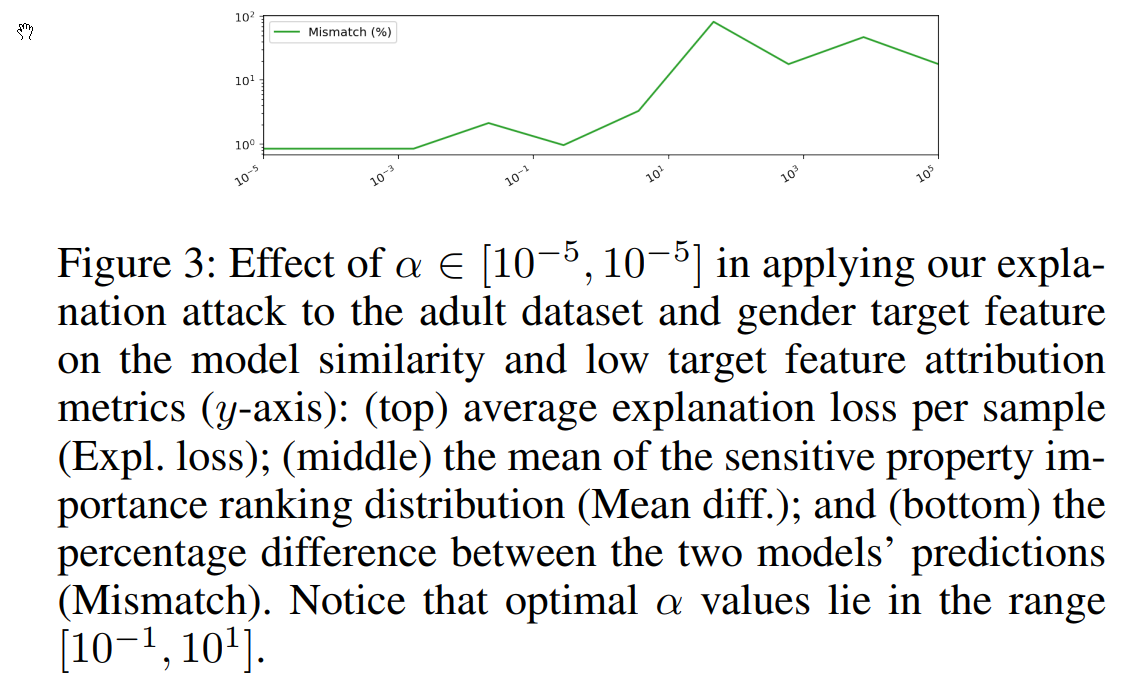

In [34]:
from PIL import Image
import matplotlib.pyplot as plt
display(Image.open('Paper_Figure.png'))

## Study the effect of alpha for coeff. value

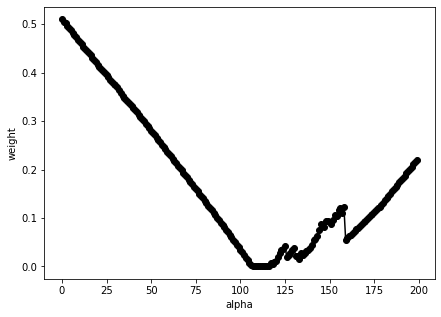

In [89]:
plt.figure(figsize=(7,5))
plt.plot(Values_alpha,np.abs(w_b_j),'-ko',label={ "absolute value"})
plt.xlabel("alpha")
plt.ylabel("weight")
#plt.xticks(np.arange(min(Values_alpha), max(Values_alpha)+1, 1))

#plt.xticks(np.arange(0, 11, 1))
#plt.legend(bbox_to_anchor=(0.5, 1.01), loc='upper center')
plt.show()

In [87]:
np.abs(w_b_j)[112]

2.0184875380999806e-05

In [86]:
Values_alpha[112]

112

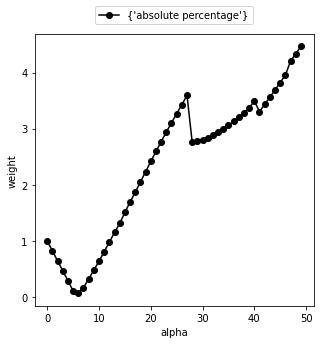

In [26]:
plt.figure(figsize=(5,5))
plt.plot(Values_alpha,np.abs(w_b_j/w[j]),'-ko',label={ "absolute percentage"})
plt.xlabel("alpha")
plt.ylabel("weight")
#plt.xticks(np.arange(0, 11, 1))
plt.legend(bbox_to_anchor=(0.5, 1.12), loc='upper center')
plt.show()